# Link: http://www.sagargv.com/blog/meta-learning-in-pytorch/

In [1]:
import math
import random
import torch # v0.4.1
from torch import nn
from torch.nn import functional as F
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def net(x, params):
    x = F.linear(x, params[0], params[1])
    x = F.relu(x)

    x = F.linear(x, params[2], params[3])
    x = F.relu(x)

    x = F.linear(x, params[4], params[5])
    return x

In [3]:
params = [
    torch.Tensor(32, 1).uniform_(-1., 1.).requires_grad_(),
    torch.Tensor(32).zero_().requires_grad_(),

    torch.Tensor(32, 32).uniform_(-1./math.sqrt(32), 1./math.sqrt(32)).requires_grad_(),
    torch.Tensor(32).zero_().requires_grad_(),

    torch.Tensor(1, 32).uniform_(-1./math.sqrt(32), 1./math.sqrt(32)).requires_grad_(),
    torch.Tensor(1).zero_().requires_grad_(),
]


In [4]:
opt = torch.optim.SGD(params, lr=1e-2)
n_inner_loop = 5
alpha = 3e-2

In [5]:
for it in range(5000):
    b = 0 if random.choice([True, False]) else math.pi

    x = torch.rand(4, 1)*4*math.pi - 2*math.pi
    y = torch.sin(x + b)

    v_x = torch.rand(4, 1)*4*math.pi - 2*math.pi
    v_y = torch.sin(v_x + b)

    opt.zero_grad()

    new_params = params
    for k in range(n_inner_loop):
        f = net(x, new_params)
        loss = F.l1_loss(f, y)

        # create_graph=True because computing grads here is part of the forward pass.
        # We want to differentiate through the SGD update steps and get higher order
        # derivatives in the backward pass.
        grads = torch.autograd.grad(loss, new_params, create_graph=True)
        new_params = [(new_params[i] - alpha*grads[i]) for i in range(len(params))]

        if it % 100 == 0: 
            print ('Iteration %d -- Inner loop %d -- Loss: %.4f' % (it, k, loss))

    v_f = net(v_x, new_params)
    loss2 = F.l1_loss(v_f, v_y)
    loss2.backward()

    opt.step()

    if it % 100 == 0: 
        print ('Iteration %d -- Outer Loss: %.4f' % (it, loss2))



Iteration 0 -- Inner loop 0 -- Loss: 0.7400
Iteration 0 -- Inner loop 1 -- Loss: 0.5275
Iteration 0 -- Inner loop 2 -- Loss: 0.4943
Iteration 0 -- Inner loop 3 -- Loss: 0.5576
Iteration 0 -- Inner loop 4 -- Loss: 0.5363
Iteration 0 -- Outer Loss: 0.4755
Iteration 100 -- Inner loop 0 -- Loss: 0.8453
Iteration 100 -- Inner loop 1 -- Loss: 0.7443
Iteration 100 -- Inner loop 2 -- Loss: 0.6390
Iteration 100 -- Inner loop 3 -- Loss: 0.5331
Iteration 100 -- Inner loop 4 -- Loss: 0.4946
Iteration 100 -- Outer Loss: 0.5872
Iteration 200 -- Inner loop 0 -- Loss: 0.8210
Iteration 200 -- Inner loop 1 -- Loss: 0.7720
Iteration 200 -- Inner loop 2 -- Loss: 0.7262
Iteration 200 -- Inner loop 3 -- Loss: 0.6882
Iteration 200 -- Inner loop 4 -- Loss: 0.6474
Iteration 200 -- Outer Loss: 0.4093
Iteration 300 -- Inner loop 0 -- Loss: 0.8009
Iteration 300 -- Inner loop 1 -- Loss: 0.7925
Iteration 300 -- Inner loop 2 -- Loss: 0.7841
Iteration 300 -- Inner loop 3 -- Loss: 0.7756
Iteration 300 -- Inner loop 4 

Iteration 3100 -- Inner loop 0 -- Loss: 0.6899
Iteration 3100 -- Inner loop 1 -- Loss: 0.6782
Iteration 3100 -- Inner loop 2 -- Loss: 0.6664
Iteration 3100 -- Inner loop 3 -- Loss: 0.6542
Iteration 3100 -- Inner loop 4 -- Loss: 0.6415
Iteration 3100 -- Outer Loss: 0.5859
Iteration 3200 -- Inner loop 0 -- Loss: 0.4867
Iteration 3200 -- Inner loop 1 -- Loss: 0.4821
Iteration 3200 -- Inner loop 2 -- Loss: 0.4776
Iteration 3200 -- Inner loop 3 -- Loss: 0.4731
Iteration 3200 -- Inner loop 4 -- Loss: 0.4696
Iteration 3200 -- Outer Loss: 0.7725
Iteration 3300 -- Inner loop 0 -- Loss: 0.4648
Iteration 3300 -- Inner loop 1 -- Loss: 0.4506
Iteration 3300 -- Inner loop 2 -- Loss: 0.4371
Iteration 3300 -- Inner loop 3 -- Loss: 0.4240
Iteration 3300 -- Inner loop 4 -- Loss: 0.4110
Iteration 3300 -- Outer Loss: 0.5117
Iteration 3400 -- Inner loop 0 -- Loss: 0.6317
Iteration 3400 -- Inner loop 1 -- Loss: 0.6035
Iteration 3400 -- Inner loop 2 -- Loss: 0.5726
Iteration 3400 -- Inner loop 3 -- Loss: 0.5

In [6]:
t_b = math.pi #0

t_x = torch.rand(4, 1)*4*math.pi - 2*math.pi
t_y = torch.sin(t_x + t_b)

opt.zero_grad()

t_params = params
for k in range(n_inner_loop):
    t_f = net(t_x, t_params)
    t_loss = F.l1_loss(t_f, t_y)

    grads = torch.autograd.grad(t_loss, t_params, create_graph=True)
    t_params = [(t_params[i] - alpha*grads[i]) for i in range(len(params))]

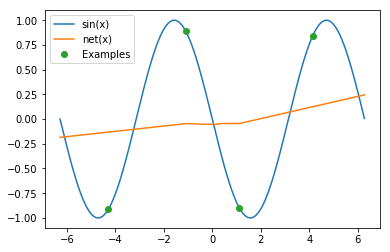

In [7]:
test_x = torch.arange(-2*math.pi, 2*math.pi, step=0.01).unsqueeze(1)
test_y = torch.sin(test_x + t_b)

test_f = net(test_x, t_params)

plt.plot(test_x.data.numpy(), test_y.data.numpy(), label='sin(x)')
plt.plot(test_x.data.numpy(), test_f.data.numpy(), label='net(x)')
plt.plot(t_x.data.numpy(), t_y.data.numpy(), 'o', label='Examples')
plt.legend()
plt.savefig('maml-sine.png')